In [11]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from process_websites import get_corpus

from sklearn.metrics import classification_report

In [12]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
FOLDER_PATH = '/home/vahidsanei_google_com/'

In [4]:
df = get_corpus(None, output_path=None, df_address_with_corpus=os.path.join(FOLDER_PATH, 'data', 'yelp_data', 'updated', 'business_with_corpus.csv'))

The dataframe already exists. We load the existing file ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5107 entries, 0 to 5106
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5107 non-null   int64  
 1   business_id     5107 non-null   object 
 2   name            5107 non-null   object 
 3   address         4863 non-null   object 
 4   city            5107 non-null   object 
 5   state           5107 non-null   object 
 6   postal_code     5101 non-null   object 
 7   latitude        5107 non-null   float64
 8   longitude       5107 non-null   float64
 9   stars           5107 non-null   float64
 10  review_count    5107 non-null   int64  
 11  is_open         5107 non-null   int64  
 12  attributes      4398 non-null   object 
 13  categories      5104 non-null   object 
 14  hours           4336 non-null   object 
 15  url             5107 non-null   object 
 16  webpage_text    5107 non-null   object 
 17  is_eng          5107 non-null   b

In [6]:
train_sz = int(len(df) * 0.8)
train = df[:train_sz]
test = df[train_sz:]

In [7]:
set(df['stars'])

{1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

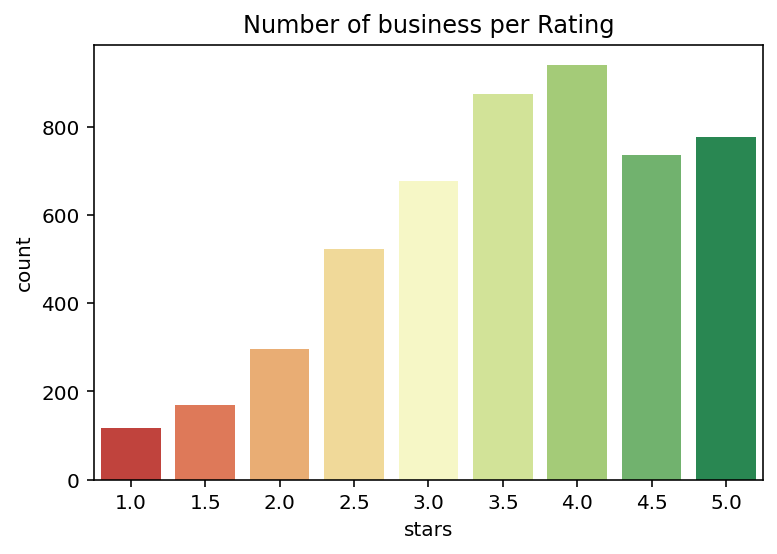

In [8]:
chart = sns.countplot(df['stars'], palette='RdYlGn')
plt.title('Number of business per Rating')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center');

In [21]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer

def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False

In [22]:
class RateWebsites:    
    def __init__(self, train, test, tokenizer: FullTokenizer, text_colname=None, label_colname=None, max_seq_len=128):
        """  
        """
        self.text_colname = 'webpage_corpus' if text_colname is None else text_colname
        if not self.text_colname in train.columns or not self.text_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the corpus.')
            return
        
        self.label_colname = 'stars' if label_colname is None else label_colname
        if not self.label_colname in train.columns or not self.label_colname in test.columns:
            print('Error: Please specify a proper column name in the input dataframe as the labels.')
            return
        
        self.classes = train[self.label_colname].unique().astype('float32').tolist()
        self.classes.sort()
        
        train = train.dropna(subset=[self.text_colname])
        test = test.dropna(subset=[self.text_colname])
        
        self.max_seq_len = 0
        self.tokenizer = tokenizer
        (self.train_x, self.train_y), (self.test_x, self.test_y) = map(self._tokanize, [train, test])
        
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._cut_with_padding, [self.train_x, self.test_x])
    
    def build_model(self, bert_config_file, bert_ckpt_file, dropout=0.5, adapter_size=64):
        """
        """
        bert = self._load_bert(bert_config_file, bert_ckpt_file, adapter_size)
        input_ = keras.layers.Input(shape=(self.max_seq_len, ), dtype='int64', name="input_ids")
        x = bert(input_)
        #get the first embedding from the output of BERT
        x = keras.layers.Lambda(lambda seq: seq[:,0,:])(x)
        
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(800, activation='relu')(x)
        #x = keras.layers.Dense(300, activation='relu')(x)
        output_ = keras.layers.Dense(units=len(self.classes), activation='softmax')(x)
        
        model = keras.Model(inputs=input_, outputs=output_)
        model.build(input_shape=(None, self.max_seq_len))
        
        load_stock_weights(bert, bert_ckpt_file)
        
        if adapter_size is not None:
            freeze_bert_layers(bert)
 
        return model
    
    def _load_bert(self, bert_config_file, bert_ckpt_file, adapter_size):
        try:
            with tf.io.gfile.GFile(bert_config_file, 'r') as gf:
                bert_config = StockBertConfig.from_json_string(gf.read())
                bert_params = map_stock_config_to_params(bert_config)
                bert_params.adapter_size = adapter_size
                bert = BertModelLayer.from_params(bert_params, name='bert')
                return bert
        except Exception as e:
            print(e)
    
    def _tokanize(self, df):
        """
        """
        X, y = [], []
        for _, entry in tqdm(df.iterrows()):
            corpus, label = entry[self.text_colname], entry[self.label_colname]
            tokens = self.tokenizer.tokenize(corpus)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            ids = self.tokenizer.convert_tokens_to_ids(tokens)
            
            if len(ids) >= 50:
                self.max_seq_len = max(self.max_seq_len, len(ids))
                X.append(ids)
                y.append(self.classes.index(label))
                
        return np.asarray(X), np.asarray(y)
    
    def _cut_with_padding(self, ids):
        """
        """
        X = []
        CLS_id = self.tokenizer.convert_tokens_to_ids(['[CLS]'])
        SEP_id = self.tokenizer.convert_tokens_to_ids(['[SEP]'])
        for token_id in ids:
            # ignore tokens '[CLS]' and '[SEP]' for now
            arr = token_id[1:-1]
            sz = min(len(arr), self.max_seq_len - 2)
            arr = CLS_id + arr[:sz] + SEP_id
            # pad the remaining cells with zero
            arr = arr + [0] * (self.max_seq_len - len(arr))
            X.append(np.asarray(arr))
        return np.asarray(X)

In [13]:
folder_path = os.path.join(FOLDER_PATH, 'data','uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for rating businesses based on their website quality!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'rating', 'businesses', 'based', 'on', 'their', 'website', 'quality', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 5790, 5661, 2241, 2006, 2037, 4037, 3737, 999]


In [19]:
def compile_model(rater:RateWebsites, model):
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])
    print(model.summary())
    history = model.fit(
        x=rater.train_x,
        y=rater.train_y,
        validation_split=0.05,
        batch_size=16,
        shuffle=True,
        epochs=10
    )

In [23]:
rater = RateWebsites(train, test, tokenizer, max_seq_len=256)

2560it [00:32, 79.08it/s] 
640it [00:08, 76.74it/s] 


In [24]:
model = rater.build_model(bert_config_file, bert_ckpt_file)

loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_1/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_8/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_8/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_8/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_1/encoder/layer_9/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_9/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

In [25]:
compile_model(rater, model)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 256, 768)          111269376 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 800)               615200    
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 7209      
Total params: 111,891,785
Trainable params: 3,038,537
Non-trainable params: 108,853,248
_____________________________________

In [26]:
loss, acc = model.evaluate(rater.test_x, rater.test_y)

19/19 [==============================] - 4s 202ms/step - loss: 2.1327 - acc: 0.2129


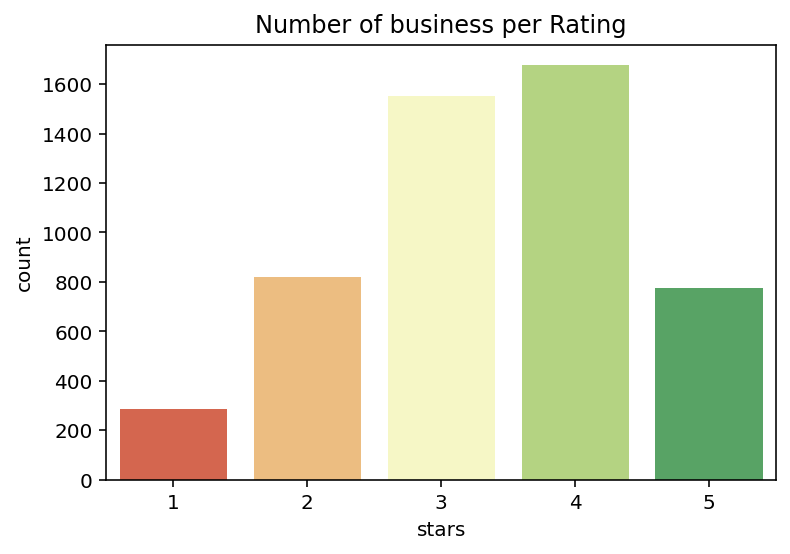

In [27]:
df2 = df.copy(deep=True)
df2['stars'] = df2['stars'].apply(lambda x: int(x))
train_sz = int(len(df) * 0.8)
train2 = df2[:train_sz]
test2 = df2[train_sz:]
chart = sns.countplot(df2['stars'], palette='RdYlGn')
plt.title('Number of business per Rating')
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='center');

In [28]:
rater2 = RateWebsites(train2, test2, tokenizer, max_seq_len=256)

2560it [00:32, 79.10it/s] 
640it [00:08, 71.69it/s]


In [29]:
model2 = rater2.build_model(bert_config_file, bert_ckpt_file)

loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_2/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_8/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_2/encoder/layer_9/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_9/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

In [30]:
compile_model(rater2, model2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 256, 768)          111269376 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 800)               615200    
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 4005      
Total params: 111,888,581
Trainable params: 3,035,333
Non-trainable params: 108,853,248
_____________________________________

In [31]:
model2.evaluate(rater2.test_x, rater2.test_y)

19/19 [==============================] - 4s 202ms/step - loss: 1.5138 - acc: 0.3560


[1.5138190984725952, 0.35604768991470337]

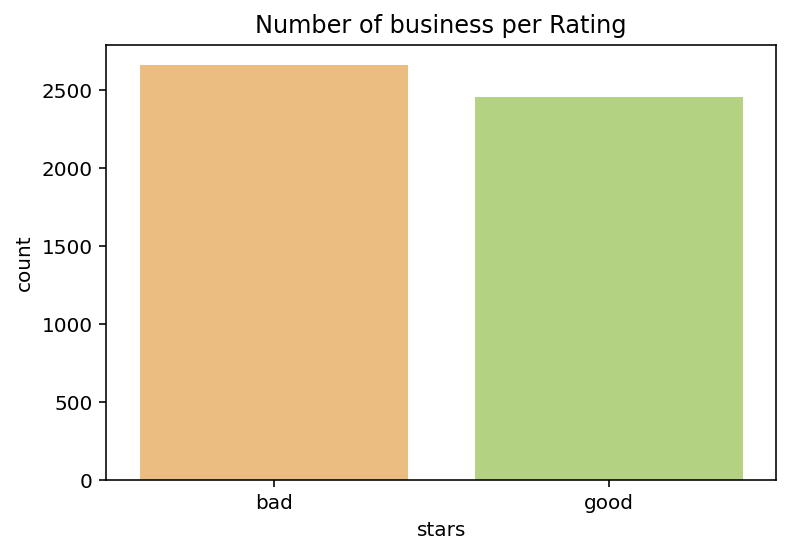

In [32]:
df3 = df.copy(deep=True)
df3['stars'] = df3['stars'].apply(lambda x: 0 if int(x) <= 3 else 1)
train_sz = int(len(df3) * 0.8)
train3 = df3[:train_sz]
test3 = df3[train_sz:]
chart = sns.countplot(df3['stars'], palette='RdYlGn')
plt.title('Number of business per Rating')
chart.set_xticklabels(['bad', 'good'], horizontalalignment='center');

In [33]:
rater3 = RateWebsites(train3, test3, tokenizer, max_seq_len=256)

2560it [00:33, 77.05it/s] 
640it [00:08, 75.84it/s]


In [34]:
model3 = rater3.build_model(bert_config_file, bert_ckpt_file)

loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_0/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer

loader: No value for:[bert_3/encoder/layer_8/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-down/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_8/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-down/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_8/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_8/output/adapter-up/kernel] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_8/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_8/output/adapter-up/bias] in:[/home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert_3/encoder/layer_9/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_9/attention/output/adapter-down/kernel] in:[/home/vahidsanei_google_c

In [35]:
compile_model(rater3, model3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 256, 768)          111269376 
_________________________________________________________________
lambda_3 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 800)               615200    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1602      
Total params: 111,886,178
Trainable params: 3,032,930
Non-trainable params: 108,853,248
_____________________________________

In [36]:
model2.evaluate(rater3.test_x, rater3.test_y)

19/19 [==============================] - 4s 202ms/step - loss: 1.8450 - acc: 0.0000e+00


[1.8450297117233276, 0.0]